In [9]:

import os
import math as m
import time
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pre_process_functions import *
from PIL import Image
import numpy as np
import dill


## Definite the pre processing functions

In [2]:

def gen_doplet_v5(sigma,volume0,rneedle=0.5):
    # when output=1 gSD return r_a,z_a
    r_a,z_a=genSingleDrop(sigma=sigma,volume0=volume0,rneedle=rneedle,output=1)
    wmax=2*max(abs(r_a))

    # use plt generate synthetic image and save as arrayd
    plt.fill_between(r_a,z_a,color='black')
    plt.fill_between(-r_a,z_a,color='black')
    plt.axis('equal')
    plt.axis('off')

    figure = plt.gcf().canvas
    ag = figure.switch_backends(FigureCanvasAgg)
    ag.draw()
    plt.close()
    A = np.asarray(ag.buffer_rgba())
    syn_array = np.rint(A[...,:3] @ [0.2126, 0.7152, 0.0722]).astype(np.uint8)
    

    return syn_array,wmax,rneedle

def crop_margin_array_v5(syn_array):#(DONE)
        
        (row,col)=syn_array.shape
        img=syn_array

        for i in range(row-1):
                if sum(img[i])!=255*col:
                        cut1=i
                        break               

        for i in range(row-1,0,-1):
                if sum(img[i])!=255*col:
                        cut2=i
                        break 

        _,img1,_=np.split(img,[cut1,cut2])  

        for i in range(col-1):
                if sum(img[:,i])!=255*row:
                        cut3=i
                        break

        for i in range(col-1,0,-1):
                if sum(img[:,i])!=255*row:
                        cut4=i
                        break

        _,cm_arr,_=np.split(img1,[cut3,cut4],axis=1)

        return cm_arr

def resize_syn_arr(syn_arr_cm,wmax,r_syn=1):
    syn_img = Image.fromarray(syn_arr_cm)
    w,h=syn_img.size
    r_syn=1
    w_n=wmax/(2*r_syn)*50
    scaling=w_n/w
    h_n=scaling*h
    new_syn=syn_img.resize((int(w_n),int(h_n)))
    syn_arr_rs=np.asarray(new_syn)

    return syn_arr_rs

def remove_needle_centering_v5(img_ori):#(Need Test)
    '''img_ori=Image.open(path_ori)'''
    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to width 300

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    for j in range(needle.shape[0]-1):
        j=j+1
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                end=end+1
    #print(stopline)

    addpad=right_edge[stopline]-needle[stopline]/2-w_ori2/2

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
    
    h_won,w_won=img_WON.shape
    
    # centering
    if addpad>0:
        img_won=np.hstack( ( img_WON,np.ones((h_won,abs(int(addpad*4))))*255 ) )
    elif addpad<0:
        img_won=np.hstack( ( np.ones((h_won,abs(int(addpad*4))))*255,img_WON ) )
    else:
        img_won=img_WON

    return img_won,needle

def cost_v3(img_ori,img_syn,width=100,output=0):
    '''
    input:              
    x:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    output: 0 -->lost, 1-->C, else C,lost
    '''
    img_syn = Image.fromarray(img_syn)
    img_ori = Image.fromarray(img_ori)

    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(abs((w_syn2-w_ori2)/2))

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    droplet=0
    for i in range(w_ori2):
        for j in range (h_ori2):
            if A[i,j]==255:
                droplet=droplet+1

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    #lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    
    lost=f/droplet
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

## Definite the obtimize funciton

In [5]:
def obtimize_v5(sv,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),output=0,append=1):
    '''need initialize xs and losts if output==0'''
    start = time.time()
    sigma=sv[0]
    v0=sv[1]

    # preprosessing the ori image
    ori,needle=remove_needle_centering_v5(Image.open(path_ori))
    pixel_needle=needle[0]

    # gen and post processing the syn image
    syn_arr,wmax,rneedle=gen_doplet_v5(sigma=sigma,volume0=v0,rneedle=0.5)

    #crop the margin of syn image
    syn_arr_cm=crop_margin_array_v5(syn_arr)
    syn=resize_syn_arr(syn_arr_cm,wmax,r_syn=1)

    end = time.time()
    #print('Obtimize Program execution time: ',end - start)

    if output==0:
        lost=cost_v3(ori,syn,output=output)
        if append==1:
            print ('saving x and lost')
            xs.append(sv)
            losts.append(lost)
        return lost
    elif output==1:
        C=cost_v3(ori,syn,output=output)
        return C
    else :
        C,lost=cost_v3(ori,syn,output=output)
        return C, lost


## Start the optimization

In [23]:
import scipy.optimize
# use scipy obtimaize the parameter
opStart=time.time()
print('Optimization Start')
xs=[]
losts=[]
x0=np.asarray((70,14))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
res=scipy.optimize.minimize(obtimize_v5,x0,method='nelder-mead',options={'maxiter':10})
opEnd=time.time()
print('Optimize Program Running Time: ',opEnd-opStart)

Optimization Start
Obtimize Program execution time:  2.3969929218292236
[70. 14.] 0.052799362422793386
Obtimize Program execution time:  2.4665732383728027
[73.5 14. ] 0.056186491332934844
Obtimize Program execution time:  2.3851864337921143
[70.  14.7] 0.03187886033074318
Obtimize Program execution time:  2.3127198219299316
[66.5 14.7] 0.027694759912333135
Obtimize Program execution time:  2.45430850982666
[63.   15.05] 0.04662283323371189
Obtimize Program execution time:  2.409891366958618
[66.5 15.4] 0.04363419007770472
Obtimize Program execution time:  2.9488251209259033
[67.375 15.05 ] 0.029886431560071727
Obtimize Program execution time:  2.6368329524993896
[63.875 15.05 ] 0.04582586172544331
Obtimize Program execution time:  2.659160852432251
[68.46875 14.7875 ] 0.025303845387527397
Obtimize Program execution time:  3.2355053424835205
[67.59375 14.4375 ] 0.032277346084877465
Obtimize Program execution time:  2.879615545272827
[67.4296875 14.896875 ] 0.028093245666467422
Obtimize

In [21]:
print(res)

 final_simplex: (array([[71.62353516, 14.89448242],
       [71.71875   , 14.940625  ],
       [71.19689941, 14.90311279]]), array([0.02450687, 0.02470612, 0.02590157]))
           fun: 0.024506873879258817
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 22
           nit: 10
        status: 2
       success: False
             x: array([71.62353516, 14.89448242])


### Save the Optimization Result (IF NEED)

In [ ]:
# save all varables
import dill
filename='./optimization_results_75_9.pkl'
dill.dump_session(filename)

In [ ]:
import dill
dill.load_session( './optimization results.pkl')

## Plot the Trace Image

In [11]:
# Import the Cost Map Data: sigma, volume, lost2d_all, lost2d_part
dill.load_session( './GlobalGrid_v1.0.pkl')

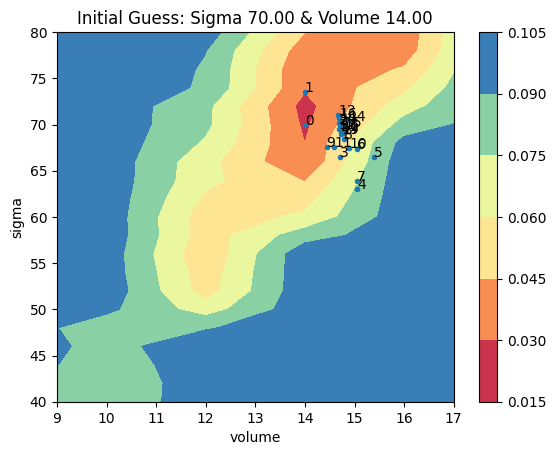

In [24]:
# write the value of all cost>0.1 elements in lost2d_all to 0.1
#lost2d_part=lost2d_all+0
#lost2d_part[lost2d_part > 0.1] = 0.1

arxs=np.asarray(xs)
x=arxs[:,0]
y=arxs[:,1]
z=losts

fig, ax = plt.subplots()
cs = ax.contourf(volume, sigma, lost2d_part, cmap=plt.get_cmap('Spectral'))
im = ax.scatter(y,x,marker='.')


n=np.arange(y.shape[0])
for i,txt in enumerate(n):
    ax.annotate(txt,(y[i],x[i]))
#添加colorbar
cbar = fig.colorbar(cs)

plt.xlabel('volume')#x轴从1到7.1
plt.ylabel('sigma')#y轴从40到100

plt.xlim((9,17))
plt.ylim((40,80))

plt.title('Initial Guess: Sigma %.2f & Volume %.2f'%(x0[0], x0[1]))

plt.show()